##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Day 1 - Prompting

Welcome to the Kaggle 5-day Generative AI course!

This notebook will show you how to get started with the Gemini API and walk you through some of the example prompts and techniques that you can also read about in the Prompting whitepaper. You don't need to read the whitepaper to use this notebook, but the papers will give you some theoretical context and background to complement this interactive notebook.


## Before you begin

In this notebook, you'll start exploring prompting using the Python SDK and AI Studio. For some inspiration, you might enjoy exploring some apps that have been built using the Gemini family of models. Here are a few that we like, and we think you will too.

* [TextFX](https://textfx.withgoogle.com/) is a suite of AI-powered tools for rappers, made in collaboration with Lupe Fiasco,
* [SQL Talk](https://sql-talk-r5gdynozbq-uc.a.run.app/) shows how you can talk directly to a database using the Gemini API,
* [NotebookLM](https://notebooklm.google/) uses Gemini models to build your own personal AI research assistant.


## For help

**Common issues are covered in the [FAQ and troubleshooting guide](https://www.kaggle.com/code/markishere/day-0-troubleshooting-and-faqs).**

## New for Gemini 2.0!

This course material was first launched in November 2024. The AI and LLM space is moving incredibly fast, so we have made some updates to use the latest models and capabilities.

* These codelabs have been updated to use the Gemini 2.0 family of models.
* The Python SDK has been updated from `google-generativeai` to the new, unified [`google-genai`](https://pypi.org/project/google-genai) SDK.
  * This new SDK works with both the developer Gemini API as well as Google Cloud Vertex AI, and switching is [as simple as changing some fields](https://pypi.org/project/google-genai/#:~:text=.Client%28%29-,API%20Selection,-By%20default%2C%20the).
* New model capabilities have been added to the relevant codelabs, such as "thinking mode" in this lab.
* Day 1 includes a new [Evaluation codelab](https://www.kaggle.com/code/markishere/day-1-evaluation-and-structured-output).

## Get started with Kaggle notebooks

If this is your first time using a Kaggle notebook, welcome! You can read about how to use Kaggle notebooks [in the docs](https://www.kaggle.com/docs/notebooks).

First, you will need to phone verify your account at kaggle.com/settings.

![](https://storage.googleapis.com/kaggle-media/Images/5dgai_0.png)
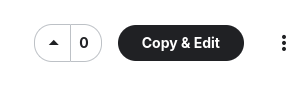
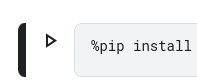

To run this notebook, as well as the others in this course, you will need to make a copy, or fork, the notebook. Look for the `Copy and Edit` button in the top-right, and **click it** to make an editable, private copy of the notebook. It should look like this one:

![Copy and Edit button](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_1.png)

Your copy will now have a ▶️ **Run** button next to each code cell that you can press to execute that cell. These notebooks are expected to be run in order from top-to-bottom, but you are encouraged to add new cells, run your own code and explore. If you get stuck, you can try the `Factory reset` option in the `Run` menu, or head back to the original notebook and make a fresh copy.

![Run cell button](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_2.png)

### Problems?

If you have any problems, head over to the [Kaggle Discord](https://discord.com/invite/kaggle), find the [`#5dgai-q-and-a` channel](https://discord.com/channels/1101210829807956100/1303438695143178251) and ask for help.

## Get started with the Gemini API

All of the exercises in this notebook will use the [Gemini API](https://ai.google.dev/gemini-api/) by way of the [Python SDK](https://pypi.org/project/google-genai/). Each of these prompts can be accessed directly in [Google AI Studio](https://aistudio.google.com/) too, so if you would rather use a web interface and skip the code for this activity, look for the <img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> AI Studio link on each prompt.

Next, you will need to add your API key to your Kaggle Notebook as a Kaggle User Secret.

![](https://storage.googleapis.com/kaggle-media/Images/5dgai_1.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_2.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_3.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_4.png)

### Install the SDK

In [1]:
!pip uninstall -qy jupyterlab  # Remove unused packages from Kaggle's base image that conflict
!pip install -U -q "google-genai==1.7.0"

Import the SDK and some helpers for rendering the output.

In [2]:
from google import genai
from google.genai import types

from IPython.display import HTML, Markdown, display

Set up a retry helper. This allows you to "Run all" without worrying about per-minute quota.

In [3]:
from google.api_core import retry


is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [5]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)
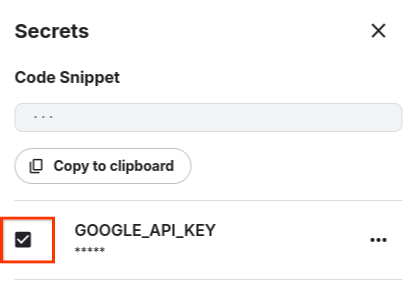

### Run your first prompt

In this step, you will test that your API key is set up correctly by making a request.

The Python SDK uses a [`Client` object](https://googleapis.github.io/python-genai/genai.html#genai.client.Client) to make requests to the API. The client lets you control which back-end to use (between the Gemini API and Vertex AI) and handles authentication (the API key).

The `gemini-2.0-flash` model has been selected here.

**Note**: If you see a `TransportError` on this step, you may need to **🔁 Factory reset** the notebook one time.

In [6]:
client = genai.Client(api_key=GOOGLE_API_KEY)

# 'client' is the main variable that our AI model is stored in, so everything we do with it will come from calling methods from 'client'
# We're specifying that we want a model to generate content and to that we must set some parameters: model type, and the prompt itself labeled as 'contents'
# The generated output must always be saved to a variable first before it can be printed or otherwise manipulated. And in doing so, the 'text' method must be called from said variable
response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents="Explain AI to me like I'm a kid.")

print(response.text)

Okay, imagine you have a really, REALLY smart puppy. 

This puppy can learn new tricks, but instead of being taught by treats, it's taught by lots and lots of examples.

**Let's say you want to teach the puppy to recognize pictures of cats.**

*   **First, you show the puppy tons and tons of pictures of cats.** Cats with long fur, short fur, sleeping cats, playing cats, black cats, orange cats!
*   **Then you show the puppy pictures that AREN'T cats:** Dogs, houses, cars, trees.
*   **The puppy looks at all those pictures and starts to notice patterns.** "Hmm, cats usually have pointy ears, whiskers, and a furry tail."
*   **The more pictures you show it, the better it gets at guessing!** If the puppy sees a new picture, it can use what it learned to say "That looks like a cat!" or "Nope, that's not a cat."

**That's kind of like AI!**

AI is like a super-smart computer program that can learn from lots of information, just like our puppy learns from lots of pictures.

Instead of pictur

The response often comes back in markdown format, which you can render directly in this notebook.

In [7]:
Markdown(response.text)

Okay, imagine you have a really, REALLY smart puppy. 

This puppy can learn new tricks, but instead of being taught by treats, it's taught by lots and lots of examples.

**Let's say you want to teach the puppy to recognize pictures of cats.**

*   **First, you show the puppy tons and tons of pictures of cats.** Cats with long fur, short fur, sleeping cats, playing cats, black cats, orange cats!
*   **Then you show the puppy pictures that AREN'T cats:** Dogs, houses, cars, trees.
*   **The puppy looks at all those pictures and starts to notice patterns.** "Hmm, cats usually have pointy ears, whiskers, and a furry tail."
*   **The more pictures you show it, the better it gets at guessing!** If the puppy sees a new picture, it can use what it learned to say "That looks like a cat!" or "Nope, that's not a cat."

**That's kind of like AI!**

AI is like a super-smart computer program that can learn from lots of information, just like our puppy learns from lots of pictures.

Instead of pictures of cats, AI can learn to:

*   **Understand what you say:** Like Siri or Alexa! They've learned to understand different voices and words.
*   **Play games:** AI can learn to play chess or video games really, really well!
*   **Help doctors:** AI can look at lots of medical images to help doctors find things they might have missed.
*   **Drive cars:** Self-driving cars learn from lots of data about roads, traffic, and signs.

**So, AI is basically a computer program that can learn from lots of examples and get better at doing things over time.** It's like having a really, really smart helper that can do lots of cool things!

Is that a good explanation? Do you have any more questions?


### Start a chat

The previous example uses a single-turn, text-in/text-out structure, but you can also set up a multi-turn chat structure too.

In [8]:
# How do we use the history parameter? Leaving it blank might give it it's default behavior, while an input could be used to delimit its capabilities. NEED TO CONFIRM
chat = client.chats.create(model='gemini-2.0-flash', history=[])
response = chat.send_message('Hello! My name is Zlork.')
print(response.text)

Hello Zlork! It's nice to meet you. How can I help you today?



In [9]:
response = chat.send_message('Can you tell me something interesting about dinosaurs?')
print(response.text)

Okay, here's a fun fact about dinosaurs:

**Did you know that many dinosaurs likely had feathers, not just scales?**

While we often picture dinosaurs as scaly reptiles, evidence suggests that many species, especially those closely related to birds like Velociraptor and Tyrannosaurus Rex (at least juveniles), had feathers. These feathers likely served purposes like insulation, display (attracting mates), and eventually, in some species, flight.  The discovery of feathered dinosaurs has revolutionized our understanding of dinosaur evolution and their relationship to birds.

Is there anything else you'd like to know about dinosaurs? I can tell you about specific dinosaurs, their diets, habitats, or anything else that piques your interest.



In [10]:
Markdown(response.text)

Okay, here's a fun fact about dinosaurs:

**Did you know that many dinosaurs likely had feathers, not just scales?**

While we often picture dinosaurs as scaly reptiles, evidence suggests that many species, especially those closely related to birds like Velociraptor and Tyrannosaurus Rex (at least juveniles), had feathers. These feathers likely served purposes like insulation, display (attracting mates), and eventually, in some species, flight.  The discovery of feathered dinosaurs has revolutionized our understanding of dinosaur evolution and their relationship to birds.

Is there anything else you'd like to know about dinosaurs? I can tell you about specific dinosaurs, their diets, habitats, or anything else that piques your interest.


While you have the `chat` object alive, the conversation state
persists. Confirm that by asking if it knows the user's name.

In [11]:
response = chat.send_message('Do you remember what my name is?')
print(response.text)

Yes, your name is Zlork.



### Choose a model

The Gemini API provides access to a number of models from the Gemini model family. Read about the available models and their capabilities on the [model overview page](https://ai.google.dev/gemini-api/docs/models/gemini).

In this step you'll use the API to list all of the available models.

In [12]:
for model in client.models.list():
  print(model.name)

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01-21
models/gemini-2.0-flash-thinking

The [`models.list`](https://ai.google.dev/api/models#method:-models.list) response also returns additional information about the model's capabilities, like the token limits and supported parameters.

In [13]:
from pprint import pprint

for model in client.models.list():
  if model.name == 'models/gemini-2.0-flash':
    pprint(model.to_json_dict())
    break

{'description': 'Gemini 2.0 Flash',
 'display_name': 'Gemini 2.0 Flash',
 'input_token_limit': 1048576,
 'name': 'models/gemini-2.0-flash',
 'output_token_limit': 8192,
 'supported_actions': ['generateContent', 'countTokens'],
 'tuned_model_info': {},
 'version': '2.0'}


## Explore generation parameters



### Output length

When generating text with an LLM, the output length affects cost and performance. Generating more tokens increases computation, leading to higher energy consumption, latency, and cost.

To stop the model from generating tokens past a limit, you can specify the `max_output_tokens` parameter when using the Gemini API. Specifying this parameter does not influence the generation of the output tokens, so the output will not become more stylistically or textually succinct, but it will stop generating tokens once the specified length is reached. Prompt engineering may be required to generate a more complete output for your given limit.

In [14]:
# In order to limit output tokens, 'types' must be imported in
# This generatecontentconfig method is called in order to input the numerical limit of tokens and must be assigned to a variable. This variable will be used in the 'config' parameter
# In the output below, we can confirm that denoting a numerical limit to tokens will cause the model to CUT OFF, not generate a more succint response within that defined token limit
from google.genai import types

short_config = types.GenerateContentConfig(max_output_tokens=200)

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=short_config,
    contents='Write a 1000 word essay on the importance of olives in modern society.')

print(response.text)

## The Humble Olive: A Cornerstone of Modern Society

The olive, a small but mighty fruit with a history stretching back millennia, plays a surprisingly significant role in modern society. More than just a topping for pizzas or a component of Mediterranean salads, olives and their oil are interwoven into our diets, economies, cultures, and even our understanding of health and sustainability. From the supermarket shelves to the research labs, the olive's influence resonates far beyond its humble appearance.

Perhaps the most obvious contribution of olives lies in their nutritional value and culinary versatility. Olive oil, extracted from the fruit, is lauded as a cornerstone of the Mediterranean diet, consistently ranked among the healthiest eating patterns globally. Its rich monounsaturated fat content, particularly oleic acid, is associated with reduced risk of cardiovascular disease, improved cholesterol levels, and enhanced cognitive function. Moreover, olive oil is packed with anti

In [15]:
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=short_config,
    contents='Write a short poem on the importance of olives in modern society.')

print(response.text)

From ancient groves, a taste remains,
Olive's fruit, in modern veins.
Oil to soothe, a vibrant hue,
Pesto's punch, a pizza's cue.

Tapenade on crusty bread,
A simple feast, expertly spread.
From salads bright to dishes bold,
A story in each drop unfolds.

Though progress churns, and markets swell,
The olive's grace, we know so well.
A humble fruit, a vital part,
Of modern life, and cherished art.



In [19]:
# Verifying how many words/tokens are contained in the above code cell
import re

def count_words(text):
  """Counts the number of words in a given text string.

  Args:
    text: The string of text to analyze.

  Returns:
    The number of words in the text.
  """
  if not isinstance(text, str):
    raise TypeError("Input must be a string.")

  # Use regex to find all words (sequences of alphanumeric characters and underscores)
  words = re.findall(r'\b\w+\b', text.lower()) # Convert to lowercase for consistency

  return len(words)

count_words(response.text)

72

Explore with your own prompts. Try a prompt with a restrictive output limit and then adjust the prompt to work within that limit.

In [24]:
short_config = types.GenerateContentConfig(max_output_tokens=400)

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=short_config,
    contents="Write a 500 word essay on Kant's categorical imperative")

print(response.text)

## The Unwavering Moral Compass: Exploring Kant's Categorical Imperative

Immanuel Kant, a towering figure in modern philosophy, sought to establish a system of ethics grounded not in fleeting emotions or societal customs, but in reason itself. Central to his ethical framework is the Categorical Imperative, a universal principle designed to guide our actions towards moral rectitude. This essay will explore the nuances of Kant's Categorical Imperative, highlighting its core principles and analyzing its profound implications for ethical decision-making.

The foundation of Kantian ethics lies in the concept of good will. For Kant, the only thing that is intrinsically good is a good will, defined as the will that acts according to duty. Duty, in turn, is determined by the moral law, which Kant believes can be discovered through reason. This leads us to the Categorical Imperative, which dictates how we should act to fulfill our moral duty. Unlike hypothetical imperatives, which depend on ou

In [25]:
Markdown(response.text)

## The Unwavering Moral Compass: Exploring Kant's Categorical Imperative

Immanuel Kant, a towering figure in modern philosophy, sought to establish a system of ethics grounded not in fleeting emotions or societal customs, but in reason itself. Central to his ethical framework is the Categorical Imperative, a universal principle designed to guide our actions towards moral rectitude. This essay will explore the nuances of Kant's Categorical Imperative, highlighting its core principles and analyzing its profound implications for ethical decision-making.

The foundation of Kantian ethics lies in the concept of good will. For Kant, the only thing that is intrinsically good is a good will, defined as the will that acts according to duty. Duty, in turn, is determined by the moral law, which Kant believes can be discovered through reason. This leads us to the Categorical Imperative, which dictates how we should act to fulfill our moral duty. Unlike hypothetical imperatives, which depend on our desires and are conditional ("If you want X, then do Y"), the Categorical Imperative is unconditional and applies to everyone, regardless of their personal goals or circumstances.

Kant formulates the Categorical Imperative in several ways, each offering a slightly different perspective on the same fundamental principle. The first, and arguably most well-known, formulation is the Formula of Universal Law: "Act only according to that maxim whereby you can at the same time will that it should become a universal law." This essentially means that before acting, we must consider whether our action could be universally applied to everyone without contradiction. If the action, when universalized, leads to a logical or practical impossibility, then it is morally wrong. For example, lying is impermissible under this formulation. If everyone lied, trust would erode, and communication would become impossible. Therefore, the maxim of lying cannot be universalized without contradiction.

The second formulation, the Formula of Humanity, emphasizes the inherent dignity and worth of every rational being. It states

In [26]:
count_words(response.text)
# Only 322? What else is counted as a token by Gemini? It's not consisten with my counting function

322

In [30]:
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=short_config,
    contents="Write a brief summary on Kant's categorical imperative")

print(response.text)

Kant's categorical imperative is a central concept in his ethical philosophy. It's a moral principle that dictates what we *ought* to do, regardless of our desires or potential consequences. Instead of focusing on outcomes, it emphasizes acting according to principles that are universally applicable.

Essentially, the categorical imperative comes in a few formulations, but they all boil down to these core ideas:

*   **Act only according to a maxim whereby you can at the same time will that it should become a universal law.** (Universality Formulation):  Only do something if you believe everyone could do it without creating a contradiction.
*   **Act in such a way that you treat humanity, whether in your own person or in the person of any other, never merely as a means to an end, but always at the same time as an end.** (Humanity Formulation):  Treat all people, including yourself, as valuable and deserving of respect, not just as tools to get what you want.

In essence, the categorica

In [31]:
count_words(response.text)

188

### Temperature

Temperature controls the degree of randomness in token selection. Higher temperatures result in a higher number of candidate tokens from which the next output token is selected, and can produce more diverse results, while lower temperatures have the opposite effect, such that a temperature of 0 results in greedy decoding, selecting the most probable token at each step.

Temperature doesn't provide any guarantees of randomness, but it can be used to "nudge" the output somewhat.

In [32]:
# We must onfigure the temperature in the same way as we did the token limit. However, can we assign more than one variable to the config parameter?
high_temp_config = types.GenerateContentConfig(temperature=2.0)

# This for loop ensures that only 5 colors are chosen/generated by the model. Was this done because only one variable can be assigned to the config parameter?
# ANSWER: There's a max_output_tokens parameter in clients.models.generate_content. This notebook doesn't actually showcase it until the 'Prompting' section. 
# Why? Because the config parameter must be set, it can't be left blank. That's why max_output_tokens was assigned as a variable using types.GenerateContentConfig and then set to the 
# config parameter instead of simply entering the number into the max_output_tokens parameter in client.models.generate_content
for _ in range(5):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      config=high_temp_config,
      contents='Pick a random colour... (respond in a single word)')

  if response.text:
      # This print statement showcases how one can separate words/tokens with a line between each of them
    print(response.text, '-' * 25)

Orange
 -------------------------
Orange
 -------------------------
Azure.
 -------------------------
Turquoise
 -------------------------
Magenta
 -------------------------


Now try the same prompt with temperature set to zero. Note that the output is not completely deterministic, as other parameters affect token selection, but the results will tend to be more stable.

In [33]:
low_temp_config = types.GenerateContentConfig(temperature=0.0)

for _ in range(5):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      config=low_temp_config,
      contents='Pick a random colour... (respond in a single word)')

  if response.text:
    print(response.text, '-' * 25)

Azure
 -------------------------
Azure
 -------------------------
Azure
 -------------------------
Azure
 -------------------------
Azure
 -------------------------


### Top-P

Like temperature, the top-P parameter is also used to control the diversity of the model's output.

Top-P defines the probability threshold that, once cumulatively exceeded, tokens stop being selected as candidates. A top-P of 0 is typically equivalent to greedy decoding, and a top-P of 1 typically selects every token in the model's vocabulary.

You may also see top-K referenced in LLM literature. Top-K is not configurable in the Gemini 2.0 series of models, but can be changed in older models. Top-K is a positive integer that defines the number of most probable tokens from which to select the output token. A top-K of 1 selects a single token, performing greedy decoding.


Run this example a number of times, change the settings and observe the change in output.

In [34]:
model_config = types.GenerateContentConfig(
    # These are the default values for gemini-2.0-flash.
    temperature=1.0,
    top_p=0.95,
)

story_prompt = "You are a creative writer. Write a short story about a cat who goes on an adventure."
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=story_prompt)

print(response.text)

Clementine, a tortoiseshell with a perpetually surprised expression, was no ordinary housecat. While her siblings contentedly napped in sunbeams and batted at dust bunnies, Clementine dreamt of the world beyond the windowsill. She envisioned shimmering forests, roaring rivers, and mountains that kissed the clouds. Her humans, bless their oblivious hearts, thought she was simply staring at birds.

One Tuesday, during the weekly window cleaning, Clementine saw her chance. The screen, usually securely fastened, was slightly ajar. It was a sliver of opportunity, a whisper of the wild calling her name. With a surge of adrenaline that tasted suspiciously like tuna, she squeezed through the gap.

The world exploded with sensation. The crisp autumn air nipped at her whiskers, carrying the scent of decaying leaves and something else, something… spicy. This, she knew, was the adventure she’d been craving.

Her first discovery was the garden. Giant, multi-colored flowers swayed like drunken dance

In [35]:
model_config = types.GenerateContentConfig(
    temperature=1.0,
    top_p=0.5,
)

story_prompt = "You are a creative writer. Write a short story about a cat who goes on an adventure."
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=story_prompt)

print(response.text)

Jasper, a ginger tabby with a perpetually surprised expression, was not built for adventure. He preferred sunbeams, the gentle scratch of a human hand behind his ears, and the predictable rhythm of his life inside Mrs. Higgins' cozy cottage. But destiny, it seemed, had other plans.

It started with a rogue butterfly. A magnificent Monarch, wings ablaze with orange and black, fluttered past the open window, a beacon of the unknown. Jasper, usually content to watch the world from his windowsill perch, felt a twitch in his whiskers, a primal urge he couldn't ignore. He leaped.

He landed clumsily on the flowerbed, the scent of petunias filling his nostrils. The butterfly danced just beyond his reach, leading him further and further from the familiar comfort of home. He followed, a ginger blur against the green, his tail twitching with excitement.

The butterfly led him through the overgrown garden, past towering sunflowers and buzzing bees, until he reached the edge of the woods. Jasper h

In [36]:
model_config = types.GenerateContentConfig(
    temperature=1.0,
    top_p=0.1,
)

story_prompt = "You are a creative writer. Write a short story about a cat who goes on an adventure."
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=story_prompt)

print(response.text)

Clementine, a calico of discerning tastes and a perpetually unimpressed expression, considered her life utterly predictable. Wake, groom, demand breakfast, nap in sunbeam, torment dust bunnies, demand dinner, nap on human's lap, sleep. Rinse and repeat. Utterly, utterly boring.

One Tuesday, however, the boredom cracked. A rogue gust of wind, smelling of pine needles and something wild, something *un-cat-like*, blew open the back door. Clementine, mid-groom, paused. The scent was intoxicating, a siren song of the unknown.

Hesitantly, she padded to the doorway. Beyond the familiar patio lay a world of green, a jungle of towering ferns and whispering trees. Her whiskers twitched. This was not the manicured lawn she knew. This was…adventure.

With a decisive flick of her tail, Clementine stepped into the wild.

The first few steps were tentative. The grass tickled her belly, the damp earth clung to her paws. But the scent, oh, the scent! It led her deeper, past rustling bushes and over m

In [37]:
model_config = types.GenerateContentConfig(
    # These are the default values for gemini-2.0-flash.
    temperature=1.0,
    top_p=0.95,
)

story_prompt = "You are a discplined Kantian deonologist. Is it ever morally permissible to cheat on a class assignment?"
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=story_prompt)

print(response.text)

As a disciplined Kantian deontologist, my answer is a firm and unequivocal **no**. Cheating on a class assignment is *never* morally permissible. This conclusion stems directly from the core principles of Kantian ethics, specifically the Categorical Imperative. Let's break down why:

*   **The Categorical Imperative:** Kant's moral philosophy is based on the Categorical Imperative, which commands us to act according to principles that we could will to become universal laws. In other words, we must ask ourselves: could this action be universalized without contradiction?

*   **Universalizability and the Contradiction in Conception:** If we universalize cheating, we encounter a contradiction in conception. Imagine a world where everyone cheats on assignments. What happens?
    *   **The value of grades and assessments collapses:** Grades are meant to reflect actual knowledge and understanding. If cheating is widespread, grades become meaningless indicators, undermining the entire purpose

In [38]:
model_config = types.GenerateContentConfig(
    # These are the default values for gemini-2.0-flash.
    temperature=1.0,
    top_p=0.35,
)

story_prompt = "You are a discplined Kantian deonologist. Is it ever morally permissible to cheat on a class assignment?"
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=story_prompt)

print(response.text)

As a disciplined Kantian deontologist, my answer is a firm **no**. Cheating on a class assignment is never morally permissible. Here's why, based on Kantian principles:

*   **The Categorical Imperative - Universalizability:** Kant's first formulation of the Categorical Imperative asks us to act only according to a maxim that we could will to become a universal law. If I cheat, I am acting on the maxim: "It is permissible to cheat when it benefits me." If everyone adopted this maxim, the entire system of education and assessment would collapse. Grades would become meaningless, and the pursuit of genuine knowledge would be undermined. A society where cheating is universally accepted is self-defeating and therefore, the maxim cannot be universalized.

*   **The Categorical Imperative - Humanity as an End:** Kant's second formulation of the Categorical Imperative states that we should always treat humanity, whether in our own person or in the person of any other, never merely as a means t

In [39]:
model_config = types.GenerateContentConfig(
    # These are the default values for gemini-2.0-flash.
    temperature=1.0,
    top_p=0.05,
)

story_prompt = "You are a discplined Kantian deonologist. Is it ever morally permissible to cheat on a class assignment?"
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=story_prompt)

print(response.text)

As a disciplined Kantian deontologist, my answer is a firm **no**. Cheating on a class assignment is never morally permissible. Here's why, based on Kantian principles:

*   **The Categorical Imperative:** Kant's moral philosophy centers on the Categorical Imperative, which commands us to act only according to maxims that we could will to become universal laws. Let's analyze cheating through the two main formulations:

    *   **The Formula of Universal Law:** Could I will that everyone cheat on assignments? If cheating were universalized, the entire system of education would collapse. Grades would become meaningless, learning would be undermined, and trust between students and teachers would be destroyed. The very purpose of assignments – to assess understanding and promote learning – would be defeated. A world where everyone cheats is self-defeating and irrational. Therefore, the maxim "I will cheat on this assignment" cannot be universalized.

    *   **The Formula of Humanity (Trea

**My Own Note**

I need to be able to reliably evaluate Top-P configuration performance. 
I'll need to perhaps run it through scripts that find:
- diversity of word choice
- something that ranks the complexity of words used(like that Elevate app)
- something that can then rank multiple generated texts against one another by way of how well it compares to one 'perfected' generated text
  - I can do this by way of setting temp to 1.0 and top-P to 1 for the 'perfected' text, then I'll use this tool to rank all the other generated text that are created with lowered temp and top-P to confirm which of them best covers the content in the 'perfected' text while using less tokens/compute

## Prompting

This section contains some prompts from the chapter for you to try out directly in the API. Try changing the text here to see how each prompt performs with different instructions, more examples, or any other changes you can think of.

### Zero-shot

Zero-shot prompts are prompts that describe the request for the model directly.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1gzKKgDHwkAvexG5Up0LMtl1-6jKMKe4g"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [40]:
model_config = types.GenerateContentConfig(
    temperature=0.1,
    top_p=1,
    max_output_tokens=5,
)

zero_shot_prompt = """Classify movie reviews as POSITIVE, NEUTRAL or NEGATIVE.
Review: "Her" is a disturbing study revealing the direction
humanity is headed if AI is allowed to keep evolving,
unchecked. I wish there were more movies like this masterpiece.
Sentiment: """

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=zero_shot_prompt)

print(response.text)

POSITIVE



#### Enum mode

The models are trained to generate text, and while the Gemini 2.0 models are great at following instructions, other models can sometimes produce more text than you may wish for. In the preceding example, the model will output the label, but sometimes it can include a preceding "Sentiment" label, and without an output token limit, it may also add explanatory text afterwards. See [this prompt in AI Studio](https://aistudio.google.com/prompts/1gzKKgDHwkAvexG5Up0LMtl1-6jKMKe4g) for an example.

The Gemini API has an [Enum mode](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Enum.ipynb) feature that allows you to constrain the output to a fixed set of values.

In [41]:
import enum

class Sentiment(enum.Enum):
    POSITIVE = "positive"
    NEUTRAL = "neutral"
    NEGATIVE = "negative"


response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        response_mime_type="text/x.enum",
        response_schema=Sentiment
    ),
    contents=zero_shot_prompt)

print(response.text)

positive


When using constrained output like an enum, the Python SDK will attempt to convert the model's text response into a Python object automatically. It's stored in the `response.parsed` field.

In [42]:
enum_response = response.parsed
print(enum_response)
print(type(enum_response))

Sentiment.POSITIVE
<enum 'Sentiment'>


### One-shot and few-shot

Providing an example of the expected response is known as a "one-shot" prompt. When you provide multiple examples, it is a "few-shot" prompt.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1jjWkjUSoMXmLvMJ7IzADr_GxHPJVV2bg"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>


In [43]:
few_shot_prompt = """Parse a customer's pizza order into valid JSON:

EXAMPLE:
I want a small pizza with cheese, tomato sauce, and pepperoni.
JSON Response:
```
{
"size": "small",
"type": "normal",
"ingredients": ["cheese", "tomato sauce", "pepperoni"]
}
```

EXAMPLE:
Can I get a large pizza with tomato sauce, basil and mozzarella
JSON Response:
```
{
"size": "large",
"type": "normal",
"ingredients": ["tomato sauce", "basil", "mozzarella"]
}
```

ORDER:
"""

customer_order = "Give me a large with cheese & pineapple"

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        top_p=1,
        max_output_tokens=250,
    ),
    contents=[few_shot_prompt, customer_order])
    # If we make a list within the contents parameter, we can add more than just the prompt, but also an input variable, such as 'customer order'
print(response.text)

```json
{
"size": "large",
"type": "normal",
"ingredients": ["cheese", "pineapple"]
}
```



#### JSON mode

To provide control over the schema, and to ensure that you only receive JSON (with no other text or markdown), you can use the Gemini API's [JSON mode](https://github.com/google-gemini/cookbook/blob/main/quickstarts/JSON_mode.ipynb). This forces the model to constrain decoding, such that token selection is guided by the supplied schema.

In [44]:
import typing_extensions as typing

class PizzaOrder(typing.TypedDict):
    size: str
    ingredients: list[str]
    type: str


response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        response_mime_type="application/json",
        response_schema=PizzaOrder,
    ),
    contents="Can I have a large dessert pizza with apple and chocolate")

print(response.text)

{
  "size": "large",
  "ingredients": ["apple", "chocolate"],
  "type": "dessert"
}


### Chain of Thought (CoT)

Direct prompting on LLMs can return answers quickly and (in terms of output token usage) efficiently, but they can be prone to hallucination. The answer may "look" correct (in terms of language and syntax) but is incorrect in terms of factuality and reasoning.

Chain-of-Thought prompting is a technique where you instruct the model to output intermediate reasoning steps, and it typically gets better results, especially when combined with few-shot examples. It is worth noting that this technique doesn't completely eliminate hallucinations, and that it tends to cost more to run, due to the increased token count.

Models like the Gemini family are trained to be "chatty" or "thoughtful" and will provide reasoning steps without prompting, so for this simple example you can ask the model to be more direct in the prompt to force a non-reasoning response. Try re-running this step if the model gets lucky and gets the answer correct on the first try.

In [45]:
prompt = """When I was 4 years old, my partner was 3 times my age. Now, I
am 20 years old. How old is my partner? Return the answer directly."""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=prompt)

print(response.text)
# Perfect example of a hallucination. It was deterministically guided into a hallucination by stating that 'Return the answer directly.'
# This secondary instruction limited the model

68



Now try the same approach, but indicate to the model that it should "think step by step".

In [46]:
prompt = """When I was 4 years old, my partner was 3 times my age. Now,
I am 20 years old. How old is my partner? Let's think step by step."""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=prompt)

Markdown(response.text)

Here's how to solve the problem step-by-step:

1.  **Find the age difference:** When you were 4, your partner was 3 times your age, so they were 4 * 3 = 12 years old.
2.  **Calculate the age gap:** The age difference between you and your partner is 12 - 4 = 8 years.
3.  **Determine your partner's current age:** Since your partner is 8 years older than you, and you are now 20, your partner is currently 20 + 8 = 28 years old.

**Answer:** Your partner is now 28 years old.

### ReAct: Reason and act

In this example you will run a ReAct prompt directly in the Gemini API and perform the searching steps yourself. As this prompt follows a well-defined structure, there are frameworks available that wrap the prompt into easier-to-use APIs that make tool calls automatically, such as the LangChain example from the "Prompting" whitepaper.

To try this out with the Wikipedia search engine, check out the [Searching Wikipedia with ReAct](https://github.com/google-gemini/cookbook/blob/main/examples/Search_Wikipedia_using_ReAct.ipynb) cookbook example.


> Note: The prompt and in-context examples used here are from [https://github.com/ysymyth/ReAct](https://github.com/ysymyth/ReAct) which is published under an [MIT license](https://opensource.org/licenses/MIT), Copyright (c) 2023 Shunyu Yao.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/18oo63Lwosd-bQ6Ay51uGogB3Wk3H8XMO"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>


In [47]:
model_instructions = """
Solve a question answering task with interleaving Thought, Action, Observation steps. Thought can reason about the current situation,
Observation is understanding relevant information from an Action's output and Action can be one of three types:
 (1) <search>entity</search>, which searches the exact entity on Wikipedia and returns the first paragraph if it exists. If not, it
     will return some similar entities to search and you can try to search the information from those topics.
 (2) <lookup>keyword</lookup>, which returns the next sentence containing keyword in the current context. This only does exact matches,
     so keep your searches short.
 (3) <finish>answer</finish>, which returns the answer and finishes the task.
"""

example1 = """Question
Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?

Thought 1
The question simplifies to "The Simpsons" character Milhouse is named after who. I only need to search Milhouse and find who it is named after.

Action 1
<search>Milhouse</search>

Observation 1
Milhouse Mussolini Van Houten is a recurring character in the Fox animated television series The Simpsons voiced by Pamela Hayden and created by Matt Groening.

Thought 2
The paragraph does not tell who Milhouse is named after, maybe I can look up "named after".

Action 2
<lookup>named after</lookup>

Observation 2
Milhouse was named after U.S. president Richard Nixon, whose middle name was Milhous.

Thought 3
Milhouse was named after U.S. president Richard Nixon, so the answer is Richard Nixon.

Action 3
<finish>Richard Nixon</finish>
"""

example2 = """Question
What is the elevation range for the area that the eastern sector of the Colorado orogeny extends into?

Thought 1
I need to search Colorado orogeny, find the area that the eastern sector of the Colorado orogeny extends into, then find the elevation range of the area.

Action 1
<search>Colorado orogeny</search>

Observation 1
The Colorado orogeny was an episode of mountain building (an orogeny) in Colorado and surrounding areas.

Thought 2
It does not mention the eastern sector. So I need to look up eastern sector.

Action 2
<lookup>eastern sector</lookup>

Observation 2
The eastern sector extends into the High Plains and is called the Central Plains orogeny.

Thought 3
The eastern sector of Colorado orogeny extends into the High Plains. So I need to search High Plains and find its elevation range.

Action 3
<search>High Plains</search>

Observation 3
High Plains refers to one of two distinct land regions

Thought 4
I need to instead search High Plains (United States).

Action 4
<search>High Plains (United States)</search>

Observation 4
The High Plains are a subregion of the Great Plains. From east to west, the High Plains rise in elevation from around 1,800 to 7,000 ft (550 to 2,130m).

Thought 5
High Plains rise in elevation from around 1,800 to 7,000 ft, so the answer is 1,800 to 7,000 ft.

Action 5
<finish>1,800 to 7,000 ft</finish>
"""

# Come up with more examples yourself, or take a look through https://github.com/ysymyth/ReAct/

To capture a single step at a time, while ignoring any hallucinated Observation steps, you will use `stop_sequences` to end the generation process. The steps are `Thought`, `Action`, `Observation`, in that order.

In [48]:
question = """Question
Who was the youngest author listed on the transformers NLP paper?
"""

# You will perform the Action; so generate up to, but not including, the Observation.
react_config = types.GenerateContentConfig(
    stop_sequences=["\nObservation"],
    system_instruction=model_instructions + example1 + example2,
)

# Create a chat that has the model instructions and examples pre-seeded.
react_chat = client.chats.create(
    model='gemini-2.0-flash',
    config=react_config,
)

resp = react_chat.send_message(question)
print(resp.text)

Thought 1
I need to find the transformers NLP paper and identify the authors and their ages to determine the youngest author.

Action 1
<search>transformers NLP paper</search>



Now you can perform this research yourself and supply it back to the model.

In [49]:
observation = """Observation 1
[1706.03762] Attention Is All You Need
Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely.
"""
resp = react_chat.send_message(observation)
print(resp.text)

Thought 2
I have the list of authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin. I need to find their ages to determine the youngest. Since I cannot directly search their ages, I will start with the first author.

Action 2
<search>Ashish Vaswani age</search>



This process repeats until the `<finish>` action is reached. You can continue running this yourself if you like, or try the [Wikipedia example](https://github.com/google-gemini/cookbook/blob/main/examples/Search_Wikipedia_using_ReAct.ipynb) to see a fully automated ReAct system at work.

## Thinking mode

The experiemental Gemini Flash 2.0 "Thinking" model has been trained to generate the "thinking process" the model goes through as part of its response. As a result, the Flash Thinking model is capable of stronger reasoning capabilities in its responses.

Using a "thinking mode" model can provide you with high-quality responses without needing specialised prompting like the previous approaches. One reason this technique is effective is that you induce the model to generate relevant information ("brainstorming", or "thoughts") that is then used as part of the context in which the final response is generated.

Note that when you use the API, you get the final response from the model, but the thoughts are not captured. To see the intermediate thoughts, try out [the thinking mode model in AI Studio](https://aistudio.google.com/prompts/new_chat?model=gemini-2.0-flash-thinking-exp-01-21).

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1Z991SV7lZZZqioOiqIUPv9a9ix-ws4zk"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [50]:
import io
from IPython.display import Markdown, clear_output


response = client.models.generate_content_stream(
    model='gemini-2.0-flash-thinking-exp',
    contents='Who was the youngest author listed on the transformers NLP paper?',
)

# Display the response as it is streamed
buf = io.StringIO()
for chunk in response:
    buf.write(chunk.text)
    print(chunk.text, end='')

# And then render the finished response as formatted markdown.
clear_output()
Markdown(buf.getvalue())

Based on the information available, **Aidan N. Gomez** is likely the youngest author listed on the original Transformer paper, "Attention is All You Need".

Here's why:

* **"Attention is All You Need" Authors:** The authors are Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, and Illia Polosukhin.
* **Aidan N. Gomez's Background:**  At the time of the paper's publication in 2017, Aidan N. Gomez was a PhD student at the University of Oxford and was an intern at Google Brain. Being a PhD student generally indicates a younger age compared to the other authors who were already established researchers at Google Brain.
* **Other Authors' Backgrounds:** The other authors were all researchers at Google Brain, suggesting they were further along in their careers and likely older than a PhD student.

**Therefore, while we don't have exact birthdates, it's highly probable that Aidan N. Gomez was the youngest author on the "Attention is All You Need" paper due to his status as a PhD student at the time.**

It's important to note that "youngest" is based on inference from career stage.  Without explicit age information for each author at the time of publication, we cannot be absolutely certain. However, based on typical academic career paths, a PhD student contributing to such a seminal paper would likely be the youngest in a group of established researchers.

## Code prompting

### Generating code

The Gemini family of models can be used to generate code, configuration and scripts. Generating code can be helpful when learning to code, learning a new language or for rapidly generating a first draft.

It's important to be aware that since LLMs can make mistakes, and can repeat training data, it's essential to read and test your code first, and comply with any relevant licenses.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1YX71JGtzDjXQkgdes8bP6i3oH5lCRKxv"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [51]:
# The Gemini models love to talk, so it helps to specify they stick to the code if that
# is all that you want.
code_prompt = """
Write a Python function to calculate the factorial of a number. No explanation, provide only the code.
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=1,
        top_p=1,
        max_output_tokens=1024,
    ),
    contents=code_prompt)

Markdown(response.text)

```python
def factorial(n):
  """
  Calculates the factorial of a number.

  Args:
    n: A non-negative integer.

  Returns:
    The factorial of n, which is the product of all positive integers
    less than or equal to n. Returns 1 if n is 0.
    Raises a ValueError if n is negative.
  """
  if n < 0:
    raise ValueError("Factorial is not defined for negative numbers.")
  elif n == 0:
    return 1
  else:
    result = 1
    for i in range(1, n + 1):
      result *= i
    return result
```

### Code execution

The Gemini API can automatically run generated code too, and will return the output.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/11veFr_VYEwBWcLkhNLr-maCG0G8sS_7Z"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [52]:
from pprint import pprint

config = types.GenerateContentConfig(
    #Why is this tools parameter so complicated? Need it explained
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
)

code_exec_prompt = """
Generate the first 14 odd prime numbers, then calculate their sum.
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=config,
    contents=code_exec_prompt)

# Need to learn what .candidates are
# Seems that the model can separate different aspects of it's generated output by category. This is included in the .parts method
# The .content method would need to be called to get to what's contained within it, such as .parts. Must also be able to format it's
# generated output in other ways besides parts. .candidates method could be a thing due to thinking mode? Maybe?
for part in response.candidates[0].content.parts:
  pprint(part.to_json_dict())
  print("-----")

{'text': "Okay, I can do that. First, I'll generate the first 14 odd prime "
         'numbers. Remember that a prime number is a number greater than 1 '
         'that has only two divisors: 1 and itself. Also, odd numbers are not '
         'divisible by 2. The first few prime numbers are 2, 3, 5, 7, 11, and '
         'so on. Since we need only odd prime numbers, we can exclude 2 from '
         "the list. Then, I'll calculate their sum.\n"
         '\n'}
-----
{'executable_code': {'code': 'primes = [3, 5, 7, 11, 13, 17, 19, 23, 29, 31, '
                             '37, 41, 43, 47]\n'
                             'sum_of_primes = sum(primes)\n'
                             "print(f'{primes=}')\n"
                             "print(f'{sum_of_primes=}')\n",
                     'language': 'PYTHON'}}
-----
{'code_execution_result': {'outcome': 'OUTCOME_OK',
                           'output': 'primes=[3, 5, 7, 11, 13, 17, 19, 23, 29, '
                                     '31, 37,

This response contains multiple parts, including an opening and closing text part that represent regular responses, an `executable_code` part that represents generated code and a `code_execution_result` part that represents the results from running the generated code.

You can explore them individually.

In [53]:
for part in response.candidates[0].content.parts:
    if part.text:
        display(Markdown(part.text))
    elif part.executable_code:
        display(Markdown(f'```python\n{part.executable_code.code}\n```'))
    elif part.code_execution_result:
        if part.code_execution_result.outcome != 'OUTCOME_OK':
            display(Markdown(f'## Status {part.code_execution_result.outcome}'))

        display(Markdown(f'```\n{part.code_execution_result.output}\n```'))

Okay, I can do that. First, I'll generate the first 14 odd prime numbers. Remember that a prime number is a number greater than 1 that has only two divisors: 1 and itself. Also, odd numbers are not divisible by 2. The first few prime numbers are 2, 3, 5, 7, 11, and so on. Since we need only odd prime numbers, we can exclude 2 from the list. Then, I'll calculate their sum.



```python
primes = [3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47]
sum_of_primes = sum(primes)
print(f'{primes=}')
print(f'{sum_of_primes=}')

```

```
primes=[3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47]
sum_of_primes=326

```

The first 14 odd prime numbers are 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, and 47. Their sum is 326.


### Explaining code

The Gemini family of models can explain code to you too. In this example, you pass a [bash script](https://github.com/magicmonty/bash-git-prompt) and ask some questions.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1N7LGzWzCYieyOf_7bAG4plrmkpDNmUyb"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [54]:
file_contents = !curl https://raw.githubusercontent.com/magicmonty/bash-git-prompt/refs/heads/master/gitprompt.sh

explain_prompt = f"""
Please explain what this file does at a very high level. What is it, and why would I use it?

```
{file_contents}
```
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=explain_prompt)

Markdown(response.text)

This file is a Bash script designed to enhance your command-line prompt with information about the Git repository you're currently working in.  Specifically, it customizes your prompt to show:

*   **The current Git branch.**
*   **The status of your working directory:** whether there are staged, unstaged, or untracked files.
*   **Whether your branch is ahead or behind the remote branch.**
*   **Virtual environment status.**
*   **Last command execution status**

**In essence, it provides a quick visual overview of your Git status directly in your prompt, making it easier to stay informed about your repository.**

**Why would you use it?**

*   **Increased awareness:**  You immediately see the status of your Git repository without needing to run `git status` every time.
*   **Improved workflow:**  It helps you avoid common mistakes, like committing changes to the wrong branch.
*   **Customization:** It's designed to be highly configurable, allowing you to tailor the information displayed and its appearance through themes and variables.
*   **Convenience:** It provides helpful function to manage and customize the experience such as toggling git prompt, install prompt and more.

## Learn more

To learn more about prompting in depth:

* Check out the whitepaper issued with today's content,
* Try out the apps listed at the top of this notebook ([TextFX](https://textfx.withgoogle.com/), [SQL Talk](https://sql-talk-r5gdynozbq-uc.a.run.app/) and [NotebookLM](https://notebooklm.google/)),
* Read the [Introduction to Prompting](https://ai.google.dev/gemini-api/docs/prompting-intro) from the Gemini API docs,
* Explore the Gemini API's [prompt gallery](https://ai.google.dev/gemini-api/prompts) and try them out in AI Studio,
* Check out the Gemini API cookbook for [inspirational examples](https://github.com/google-gemini/cookbook/blob/main/examples/) and [educational quickstarts](https://github.com/google-gemini/cookbook/blob/main/quickstarts/).

Be sure to check out the codelabs on day 3 too, where you will explore some more advanced prompting with code execution.

And please share anything exciting you have tried in the Discord!

*- [Mark McD](https://linktr.ee/markmcd)*